<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-01-02 10:35:03.347694: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 10:35:05.886949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 292 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-01-02 10:35:05.888644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13129 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-01-02 10:35:05.889783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13129 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability:

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-01-02 10:35:08,963[INFO][140150632900416-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 192.168.66.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [3]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 256 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 128 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 335   #@param {type:"integer"}

# generate datasets
train_size= 200 #@param {type:"integer"}
test_size = 50  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=10 #@param {type:"integer"}

L_fsource = '/cic/dataset/featured_extracted/ftp-bruteforce-forward-https/' #@param {type:"string"}
L_source = '/cic/dataset/normalized_labeled/ftp-bruteforce-forward-https/' #@param {type:"string"}
L_fdata: Dataset = read_csv_in_dir_label_string(L_fsource)
L_data: Dataset = read_csv_in_dir(L_source)
L_fcount: DataFrame = L_fdata.groupby(LABEL).aggregate(Count()).to_pandas()
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lfpadding_features = sorted(list(set(features) - set(L_fdata.schema(fetch_if_missing=True).names)))
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

print ('features=', features)
print ('Lfpadding_features=', Lfpadding_features)
print ('Lpadding_features=', Lpadding_features)

L_ftrain = DataFrame.from_records(L_fdata.take(train_size * n_timesteps_in)).fillna(0)
L_ftrain[Lfpadding_features] = 0
L_ftrain[LABEL] = L_ftrain.apply(lambda x: 'Anomaly' if x['src_ip'] == '192.168.66.39' else 'Benign', axis=1)
L_ftrain[LABEL] = L_ftrain[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_ftrain = L_ftrain[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_ftrain = L_ftrain[[LABEL]].to_numpy().reshape(train_size, n_timesteps_in)

L_ftest = DataFrame.from_records(L_fdata.take(test_size * n_timesteps_in)).fillna(0)
L_ftest[Lfpadding_features] = 0
L_ftest[LABEL] = L_ftest.apply(lambda x: 'Anomaly' if x['src_ip'] == '192.168.66.39' else 'Benign', axis=1)
L_ftest[LABEL] = L_ftest[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_ftest = L_ftest[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_ftest = L_ftest[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

L_train = DataFrame.from_records(L_data.take(train_size * n_timesteps_in)).fillna(0)
L_train[Lpadding_features] = 0
L_train[LABEL] = L_ftrain[LABEL]
LX_train = L_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_train = L_train[[LABEL]].to_numpy().reshape((train_size, n_timesteps_in))

L_test = DataFrame.from_records(L_data.take(test_size * n_timesteps_in)).fillna(0)
L_test[Lpadding_features] = 0
L_test[LABEL] = L_ftest[LABEL]
LX_test = L_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_test = L_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

2023-01-02 10:35:11,385	WARNING read_api.py:256 -- The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Repartition: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
2023-01-02 10:35:15,222	WARNING read_api.py:256 -- The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 67.30it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [4]:
L_fcount

label  count()
0          77084

In [5]:
L_count

label  count()
0    0.0    77084

## Data preview

### L_ftrain preview

In [6]:
L_ftrain[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0          0           0.0         0.0          0.0         0.0         0.0   
1          0           0.0         0.0          0.0         0.0         0.0   
2          0           0.0         0.0          0.0         0.0         0.0   
3          0           0.0         0.0          0.0         0.0         0.0   
4          0           0.0         0.0          0.0         0.0         0.0   
...      ...           ...         ...          ...         ...         ...   
19995      0           0.0         0.0          0.0         0.0         0.0   
19996      0           0.0         0.0          0.0         0.0         0.0   
19997      0           0.0         0.0          0.0         0.0         0.0   
19998      0           0.0         0.0          0.0         0.0         0.0   
19999      0           0.0         0.0          0.0         0.0         0.0   

       bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                   0.0             0.0             0.0          0.0   
1                   0.0             0.0             0.0          0.0   
2                   0.0             0.0             0.0          0.0   
3                   0.0             0.0             0.0          0.0   
4                   0.0             0.0             0.0          0.0   
...                 ...             ...             ...          ...   
19995               0.0             0.0             0.0          0.0   
19996               0.0             0.0             0.0          0.0   
19997               0.0             0.0             0.0          0.0   
19998               0.0             0.0             0.0          0.0   
19999               0.0             0.0             0.0          0.0   

       bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0               0.0          0.0          0.0          0.0              0.0   
1               0.0          0.0          0.0          0.0              0.0   
2               0.0          0.0          0.0          0.0              0.0   
3               0.0          0.0          0.0          0.0              0.0   
4               0.0          0.0          0.0          0.0              0.0   
...             ...          ...          ...          ...              ...   
19995           0.0          0.0          0.0          0.0              0.0   
19996           0.0          0.0          0.0          0.0              0.0   
19997           0.0          0.0          0.0          0.0              0.0   
19998           0.0          0.0          0.0          0.0              0.0   
19999           0.0          0.0          0.0          0.0              0.0   

       bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                   0.0              0.0              0.0             0.0   
1                   0.0              0.0              0.0             0.0   
2                   0.0              0.0              0.0             0.0   
3                   0.0              0.0              0.0             0.0   
4                   0.0              0.0              0.0             0.0   
...                 ...              ...              ...             ...   
19995               0.0              0.0              0.0             0.0   
19996               0.0              0.0              0.0             0.0   
19997               0.0              0.0              0.0             0.0   
19998               0.0              0.0              0.0             0.0   
19999               0.0              0.0              0.0             0.0   

       bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0             0.0            0.0               0.0            0.0   
1             0.0            0.0               0.0            0.0   
2             0.0            0.0               0.0            0.0   
3             0.0            0.0           

In [7]:
L_ftrain[[LABEL, *features]].describe()

label  ack_flag_cnt  active_max  active_mean  active_min  \
count  20000.000000       20000.0     20000.0      20000.0     20000.0   
mean       0.036000           0.0         0.0          0.0         0.0   
std        0.186295           0.0         0.0          0.0         0.0   
min        0.000000           0.0         0.0          0.0         0.0   
25%        0.000000           0.0         0.0          0.0         0.0   
50%        0.000000           0.0         0.0          0.0         0.0   
75%        0.000000           0.0         0.0          0.0         0.0   
max        1.000000           0.0         0.0          0.0         0.0   

       active_std  bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  \
count     20000.0      2.000000e+04    20000.000000     20000.00000   
mean          0.0      1.842539e+02        9.306599         2.63540   
std           0.0      2.291602e+04      647.034576       169.15379   
min           0.0     -4.017257e+02        0.000000         0.00000   
25%           0.0      0.000000e+00        0.000000         0.00000   
50%           0.0      0.000000e+00        0.000000         0.00000   
75%           0.0      0.000000e+00        0.000000         0.00000   
max           0.0      3.221198e+06    76957.000000     23660.00000   

        bwd_iat_max  bwd_iat_mean   bwd_iat_min   bwd_iat_std   bwd_iat_tot  \
count  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04  2.000000e+04   
mean   1.032146e+05  2.561191e+03 -1.384229e+05  5.105322e+04 -8.106768e+04   
std    5.034624e+06  1.005531e+06  6.149403e+06  2.345593e+06  5.804760e+06   
min    0.000000e+00 -2.656545e+07 -3.228135e+08  0.000000e+00 -3.173459e+08   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    3.178695e+08  1.376732e+08  2.543000e+03  1.856928e+08  2.753464e+08   

       bwd_pkt_len_max  bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  \
count     20000.000000      20000.000000     20000.000000     20000.000000   
mean         30.195750         29.982840        29.616450         0.219308   
std         195.306917        194.460516       193.514362         9.669972   
min           0.000000          0.000000         0.000000         0.000000   
25%           0.000000          0.000000         0.000000         0.000000   
50%           0.000000          0.000000         0.000000         0.000000   
75%           0.000000          0.000000         0.000000         0.000000   
max        1438.000000       1438.000000      1438.000000       651.985282   

       bwd_pkts_b_avg    bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  \
count    20000.000000  20000.000000        20000.0      20000.000000   
mean         0.008805      8.628132            0.0         29.982840   
std          0.510193    337.203101            0.0        194.460516   
min          0.000000      0.000000            0.0          0.000000   
25%          0.000000      0.000000            0.0          0.000000   
50%          0.000000      0.000000            0.0          0.000000   
75%          0.000000      0.000000            0.0          0.000000   
max         58.000000  22222.222222            0.0       1438.000000   

       bwd_urg_flags  cwe_flag_count  down_up_ratio      dst_port  \
count        20000.0         20000.0   20000.000000  20000.000000   
mean             0.0             0.0       0.010569  34662.798200   
std              0.0             0.0       0.117742  28142.761209   
min              0.0             0.0       0.000000     21.000000   
25%              0.0             0.0       0.000000    443.000000   
50%              0.0             0.0       0.000000  51258.000000   
75%              0.0             0.0       0.000000  59358.000000   
max              0.0             0.0       4.000000  65519.000000   

       ece_flag_cnt  

In [8]:
DataFrame.from_records(LX_ftrain[0])

0    1    2    3    4    5    6     7    8    9    10   11   12      13   \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
..  ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...     ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0     0.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  20.0  0.0  0.0  0.0  0.0  0.0  1438.0   

       14      15   16   17   18   19      20   21   22   23       24   25   \
0      0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   9200.0  0.0   
1      0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   9200.0  0.0   
2      0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  52719.0  0.0   
3      0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   9200.0  0.0   
4      0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   9200.0  0.0   
..     ...     ...  ...  ...  ...  ...     ...  ...  ...  ...      ...  ...   
95     0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   5044.0  0.0   
96     0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0   9200.0  0.0   
97     0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0    443.0  0.0   
98     0.0     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  63098.0  0.0   
99  1438.0  1438.0  0.0  0.0  0.0  0.0  1438.0  0.0  0.0  0.0    443.0  0.0   

    26            27     28   29   30   31   32             33   34   35   \
0   1.0  1.644442e+08  797.0  0.0  0.0  0.0  0.0    2509.410289  2.0  0.0   
1   1.0  8.737467e+09   15.0  0.0  0.0  0.0  0.0  133333.333333  2.0  0.0   
2   0.0  2.437288e+07  118.0  0.0  0.0  0.0  0.0   16949.152542  2.0  0.0   
3   1.0  4.095688e+09   32.0  0.0  0.0  0.0  0.0   62500.000000  2.0  0.0   
4   1.0  1.773505e+08  739.0  0.0  0.0  0.0  0.0    2706.359946  2.0  0.0   
..  ...           ...    ...  ...  ...  ...  ...            ...  ...  ...   
95  1.0  0.000000e+00    0.0  0.0  0.0  0.0  0.0       0.000000  1.0  0.0   
96  1.0  0.000000e+00    0.0  0.0  0.0  0.0  0.0       0.000000  0.0  0.0   
97  1.0  0.000000e+00    0.0  0.0  0.0  0.0  0.0       0.000000  0.0  0.0   
98  1.0  0.000000e+00    0.0  0.0  0.0  0.0  0.0       0.000000  1.0  0.0   
99  0.0  0.000000e+00    0.0  0.0  0.0  0.0  0.0       0.000000  0.0  0.0   

    36    37   38   39   40   41   42       43       44       45   46   47   \
0   0.0  40.0  0.0  0.0  0.0  0.0  0.0  65531.0  65531.0  65531.0  0.0  0.0   
1   0.0  40.0  0.0  0.0  0.0  0.0  0.0  65531.0  65531.0  65531.0  0.0  0.0   
2   0.0  40.0  0.0  0.0  0.0  0.0  0.0   1438.0   1438.0   1438.0  0.0  0.0   
3   0.0  40.0  0.0  0.0  0.0  0.0  0.0  65531.0  65531.0  65531.0  0.0  0.0   
4   0.0  40.0  0.0  0.0  0.0  0.0  0.0  65531.0  65531.0  65531.0  0.0  0.0   
..  ...   ...  ...  ...  ...  ...  ...      ...      ...      ...  ...  ...   
95  0.0  20.0  0.0  0.0  0.0  0.0  0.0   3680.0   3680.0   3680.0  0.0  0.0   
96  0.0  20.0  0.0  0.0  0.0  0.0  0.0     52.0     52.0     52.0  0.0  0.0   
97  0.0  20.0  0.0  0.0  0.0  0.0  0.0     40.0     40.0     40.0  0.0  0.0   
98  0.0  20.0  0.0  0.0  0.0  0.0  0.0   1438.0   1438.0   1438.0  0.0  0.0   
99  0.0   0.0  0.0  0.0  0.0  0.0  0.0      0.0      0.0      0.0  0.0  0.0   

              48   49       50    51   52   53   54   55   56    57       58   \
0     2509.410289  0.0  65531.0  20.0  0.0  0.0  0.0  0.0  0.0   0.0    512.0   
1   133333.333333  0.0  65531.0  20.0  0.0  0.0  0.0  0.0 

In [9]:
DataFrame.from_records(LX_ftrain[0]).describe()

0      1      2      3      4      5      6           7      8    \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.000000  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.400000    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    5.863773    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000    0.0   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000    0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000    0.0   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0   40.000000    0.0   

         9      10     11     12           13           14           15   \
count  100.0  100.0  100.0  100.0   100.000000   100.000000   100.000000   
mean     0.0    0.0    0.0    0.0    30.360000    30.360000    30.360000   
std      0.0    0.0    0.0    0.0   202.257837   202.257837   202.257837   
min      0.0    0.0    0.0    0.0     0.000000     0.000000     0.000000   
25%      0.0    0.0    0.0    0.0     0.000000     0.000000     0.000000   
50%      0.0    0.0    0.0    0.0     0.000000     0.000000     0.000000   
75%      0.0    0.0    0.0    0.0     0.000000     0.000000     0.000000   
max      0.0    0.0    0.0    0.0  1438.000000  1438.000000  1438.000000   

         16     17           18     19           20     21     22   \
count  100.0  100.0   100.000000  100.0   100.000000  100.0  100.0   
mean     0.0    0.0    45.529465    0.0    30.360000    0.0    0.0   
std      0.0    0.0   347.572166    0.0   202.257837    0.0    0.0   
min      0.0    0.0     0.000000    0.0     0.000000    0.0    0.0   
25%      0.0    0.0     0.000000    0.0     0.000000    0.0    0.0   
50%      0.0    0.0     0.000000    0.0     0.000000    0.0    0.0   
75%      0.0    0.0     0.000000    0.0     0.000000    0.0    0.0   
max      0.0    0.0  3225.806452    0.0  1438.000000    0.0    0.0   

              23            24     25          26            27   \
count  100.000000    100.000000  100.0  100.000000  1.000000e+02   
mean     0.016667  30461.180000    0.0    0.770000  1.323281e+08   
std      0.119623  25499.239651    0.0    0.422953  9.609898e+08   
min      0.000000    443.000000    0.0    0.000000  0.000000e+00   
25%      0.000000   9200.000000    0.0    1.000000  0.000000e+00   
50%      0.000000   9200.000000    0.0    1.000000  0.000000e+00   
75%      0.000000  56627.000000    0.0    1.000000  0.000000e+00   
max      1.000000  63558.000000    0.0    1.000000  8.737467e+09   

                28           29            30            31            32   \
count  1.000000e+02   100.000000  1.000000e+02  1.000000e+02  1.000000e+02   
mean   1.173283e+06   103.100000 -1.401109e+05 -5.605785e+05  2.427581e+05   
std    8.261542e+06   958.832292  1.401147e+06  5.605796e+06  2.427555e+06   
min    0.000000e+00     0.000000 -1.401146e+07 -5.605796e+07  0.000000e+00   
25%    0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00     0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
max    6.124430e+07  9567.000000  3.767500e+02  1.060000e+02  2.427555e+07   

                 33          34     35     36          37            38   \
count     100.000000  100.000000  100.0  100.0  100.000000  1.000000e+02   
mean     2450.555626    0.840000    0.0    0.0   22.000000  5.606770e+05   
std     14815.114847    0.631177    0.0    0.0   11.191627  5.606752e+06   
min         0.000000    0.000000    0.0    0.0    0.000000  0.000000e+00   
25%         0.000000    0.000000    0.0    0.0   20.000000  0.000000e+00   
50%         0.000000    1.000000    0.0    0.0   20.000000  0.000000e+00   
75%         0.000000    1.000000    0.0    0.0   20.000000  0.000000e+00   
max    133333.333333    3.000000    0.0    0.0  100.000000  5.606752e+07   

In [10]:
DataFrame.from_records(Ly_ftrain)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   
198   0   0   0   0   0   0   1   1   0   0   0   0   0   0   0   0   1   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   1   0   0   
198   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   
198   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   1   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   
198   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   1   0   0   0   0   0   0

In [11]:
DataFrame.from_records(Ly_ftrain).describe()

0           1           2           3           4           5   \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.025000    0.030000    0.035000    0.055000    0.055000    0.035000   
std      0.156517    0.171015    0.184241    0.228552    0.228552    0.184241   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.035000    0.035000    0.030000    0.030000    0.045000    0.040000   
std      0.184241    0.184241    0.171015    0.171015    0.207824    0.196451   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.020000    0.030000    0.035000    0.020000    0.035000    0.040000   
std      0.140351    0.171015    0.184241    0.140351    0.184241    0.196451   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18          19          20          21          22          23  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.015000    0.045000    0.040000    0.050000    0.030000    0.020000   
std      0.121857    0.207824    0.196451    0.218492    0.171015    0.140351   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               24          25          26          27          28          29  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.045000    0.025000    0.030000    0.045000    0.035000    0.050000   
std      0.207824    0.156517    0.171015    0.207824    0.184241    0.218492   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               30          31          32          33          34          35  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.035000    0.045000    0.045000    0.035000    0.020000    0.010000   
std      0.184241    0.207824    0.207824    0.184241    0.140351    0.099748   
min      0.000000    0.000000    0.000000

### L_train preview

In [12]:
L_train[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0          0           0.0         0.0          0.0         0.0         0.0   
1          0           0.0         0.0          0.0         0.0         0.0   
2          0           0.0         0.0          0.0         0.0         0.0   
3          0           0.0         0.0          0.0         0.0         0.0   
4          0           0.0         0.0          0.0         0.0         0.0   
...      ...           ...         ...          ...         ...         ...   
19995      0           0.0         0.0          0.0         0.0         0.0   
19996      0           0.0         0.0          0.0         0.0         0.0   
19997      0           0.0         0.0          0.0         0.0         0.0   
19998      0           0.0         0.0          0.0         0.0         0.0   
19999      0           0.0         0.0          0.0         0.0         0.0   

       bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                   0.0             0.0             0.0          0.0   
1                   0.0             0.0             0.0          0.0   
2                   0.0             0.0             0.0          0.0   
3                   0.0             0.0             0.0          0.0   
4                   0.0             0.0             0.0          0.0   
...                 ...             ...             ...          ...   
19995               0.0             0.0             0.0          0.0   
19996               0.0             0.0             0.0          0.0   
19997               0.0             0.0             0.0          0.0   
19998               0.0             0.0             0.0          0.0   
19999               0.0             0.0             0.0          0.0   

       bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0               0.0          0.0          0.0          0.0              0.0   
1               0.0          0.0          0.0          0.0              0.0   
2               0.0          0.0          0.0          0.0              0.0   
3               0.0          0.0          0.0          0.0              0.0   
4               0.0          0.0          0.0          0.0              0.0   
...             ...          ...          ...          ...              ...   
19995           0.0          0.0          0.0          0.0              0.0   
19996           0.0          0.0          0.0          0.0              0.0   
19997           0.0          0.0          0.0          0.0              0.0   
19998           0.0          0.0          0.0          0.0              0.0   
19999           0.0          0.0          0.0          0.0              0.0   

       bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                   0.0              0.0              0.0             0.0   
1                   0.0              0.0              0.0             0.0   
2                   0.0              0.0              0.0             0.0   
3                   0.0              0.0              0.0             0.0   
4                   0.0              0.0              0.0             0.0   
...                 ...              ...              ...             ...   
19995               0.0              0.0              0.0             0.0   
19996               0.0              0.0              0.0             0.0   
19997               0.0              0.0              0.0             0.0   
19998               0.0              0.0              0.0             0.0   
19999               0.0              0.0              0.0             0.0   

       bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0             0.0            0.0               0.0            0.0   
1             0.0            0.0               0.0            0.0   
2             0.0            0.0               0.0            0.0   
3             0.0            0.0           

In [13]:
L_train[[LABEL, *features]].describe()

label  ack_flag_cnt  active_max  active_mean  active_min  \
count  20000.000000       20000.0     20000.0      20000.0     20000.0   
mean       0.036000           0.0         0.0          0.0         0.0   
std        0.186295           0.0         0.0          0.0         0.0   
min        0.000000           0.0         0.0          0.0         0.0   
25%        0.000000           0.0         0.0          0.0         0.0   
50%        0.000000           0.0         0.0          0.0         0.0   
75%        0.000000           0.0         0.0          0.0         0.0   
max        1.000000           0.0         0.0          0.0         0.0   

       active_std  bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  \
count     20000.0      20000.000000    20000.000000    20000.000000   
mean          0.0          0.000111        0.000481        0.001375   
std           0.0          0.012655        0.020831        0.018902   
min           0.0         -0.392310        0.000000        0.000000   
25%           0.0          0.000000        0.000000        0.000000   
50%           0.0          0.000000        0.000000        0.000000   
75%           0.0          0.000000        0.000000        0.000000   
max           0.0          1.000000        1.000000        1.000000   

        bwd_iat_max  bwd_iat_mean   bwd_iat_min   bwd_iat_std   bwd_iat_tot  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.001043      0.000087     -0.000459      0.000954      0.000175   
std        0.031699      0.030633      0.024595      0.030241      0.032314   
min        0.000000     -1.000000     -1.000000      0.000000     -1.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       bwd_pkt_len_max  bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  \
count     20000.000000      20000.000000     20000.000000     20000.000000   
mean          0.022160          0.022058         0.021731         0.000214   
std           0.138459          0.138230         0.137183         0.009443   
min           0.000000          0.000000         0.000000         0.000000   
25%           0.000000          0.000000         0.000000         0.000000   
50%           0.000000          0.000000         0.000000         0.000000   
75%           0.000000          0.000000         0.000000         0.000000   
max           1.000000          1.000000         1.000000         0.636704   

       bwd_pkts_b_avg    bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  \
count    20000.000000  20000.000000        20000.0      20000.000000   
mean         0.000009      0.002013            0.0          0.022058   
std          0.000498      0.040414            0.0          0.138230   
min          0.000000      0.000000            0.0          0.000000   
25%          0.000000      0.000000            0.0          0.000000   
50%          0.000000      0.000000            0.0          0.000000   
75%          0.000000      0.000000            0.0          0.000000   
max          0.056641      1.000000            0.0          1.000000   

       bwd_urg_flags  cwe_flag_count  down_up_ratio      dst_port  \
count        20000.0         20000.0   20000.000000  20000.000000   
mean             0.0             0.0       0.009168      0.528920   
std              0.0             0.0       0.093721      0.429431   
min              0.0             0.0       0.000000      0.000320   
25%              0.0             0.0       0.000000      0.006760   
50%              0.0             0.0       0.000000      0.782147   
75%              0.0             0.0       0.000000      0.905745   
max              0.0             0.0       1.000000      0.999756   

       ece_flag_cnt  

In [14]:
DataFrame.from_records(LX_train[0])

0    1    2    3    4    5    6         7    8    9    10   11   12   13   \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...  ...  ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.019531  0.0  0.0  0.0  0.0  0.0  1.0   

    14   15   16   17   18   19   20   21   22   23        24   25        26   \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.140383  0.0  0.003922   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.140383  0.0  0.003922   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.804440  0.0  0.000000   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.140383  0.0  0.003922   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.140383  0.0  0.003922   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...       ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.076967  0.0  0.003922   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.140383  0.0  0.003922   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.006760  0.0  0.003922   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.962814  0.0  0.003922   
99  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.006760  0.0  0.000000   

    27        28   29   30   31   32   33        34   35   36        37   38   \
0   1.0  0.013283  0.0  0.0  0.0  0.0  1.0  0.001953  0.0  0.0  0.039062  0.0   
1   1.0  0.000250  0.0  0.0  0.0  0.0  1.0  0.001953  0.0  0.0  0.039062  0.0   
2   1.0  0.001967  0.0  0.0  0.0  0.0  1.0  0.001953  0.0  0.0  0.039062  0.0   
3   1.0  0.000533  0.0  0.0  0.0  0.0  1.0  0.001953  0.0  0.0  0.039062  0.0   
4   1.0  0.012317  0.0  0.0  0.0  0.0  1.0  0.001953  0.0  0.0  0.039062  0.0   
..  ...       ...  ...  ...  ...  ...  ...       ...  ...  ...       ...  ...   
95  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000977  0.0  0.0  0.019531  0.0   
96  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.019531  0.0   
97  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.019531  0.0   
98  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000977  0.0  0.0  0.019531  0.0   
99  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0   

    39   40   41   42        43        44        45   46   47   48   49   \
0   0.0  0.0  0.0  0.0  1.000000  1.000000  1.000000  0.0  0.0  1.0  0.0   
1   0.0  0.0  0.0  0.0  1.000000  1.000000  1.000000  0.0  0.0  1.0  0.0   
2   0.0  0.0  0.0  0.0  1.000000  1.000000  1.000000  0.0  0.0  1.0  0.0   
3   0.0  0.0  0.0  0.0  1.000000  1.000000  1.000000  0.0  0.0  1.0  0.0   
4   0.0  0.0  0.0  0.0  1.000000  1.000000  1.000000  0.0  0.0  1.0  0.0   
..  ...  ...  ...  ...       ...       ...       ...  ...  ...  ...  ...   
95  0.0  0.0  0.0  0.0  1.000000  1.000000  1.000000  0.0  0.0  0.0  0.0   
96  0.0  0.0  0.0  0.0  0.050781  0.050781  0.050781  0.0  0.0  0.0  0.0   
97  0.0  0.0  0.0  0.0  0.039062  0.039062  0.039062  0.0  0.0  0.0  0.0   
98  0.0  0.0  0.0  0.0  1.000000  1.000000  1.000000  0.0  0.0  0.0  0.0   
99  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0   

         50        51   52   53   54   55   56        57        58        59   \
0   1.000000  0.019531  0.0  0.0  0.0  0.0  0.0  0.000000  0.500000  1.000000   
1   1.0000

In [15]:
DataFrame.from_records(LX_train[0]).describe()

0      1      2      3      4      5      6           7      8    \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.000000  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.001367    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.005726    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000    0.0   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000    0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000    0.0   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.039062    0.0   

         9      10     11     12          13          14          15     16   \
count  100.0  100.0  100.0  100.0  100.000000  100.000000  100.000000  100.0   
mean     0.0    0.0    0.0    0.0    0.021562    0.021562    0.021562    0.0   
std      0.0    0.0    0.0    0.0    0.140691    0.140691    0.140691    0.0   
min      0.0    0.0    0.0    0.0    0.000000    0.000000    0.000000    0.0   
25%      0.0    0.0    0.0    0.0    0.000000    0.000000    0.000000    0.0   
50%      0.0    0.0    0.0    0.0    0.000000    0.000000    0.000000    0.0   
75%      0.0    0.0    0.0    0.0    0.000000    0.000000    0.000000    0.0   
max      0.0    0.0    0.0    0.0    1.000000    1.000000    1.000000    0.0   

         17          18     19          20     21     22          23   \
count  100.0  100.000000  100.0  100.000000  100.0  100.0  100.000000   
mean     0.0    0.020000    0.0    0.021562    0.0    0.0    0.016667   
std      0.0    0.140705    0.0    0.140691    0.0    0.0    0.119623   
min      0.0    0.000000    0.0    0.000000    0.0    0.0    0.000000   
25%      0.0    0.000000    0.0    0.000000    0.0    0.0    0.000000   
50%      0.0    0.000000    0.0    0.000000    0.0    0.0    0.000000   
75%      0.0    0.000000    0.0    0.000000    0.0    0.0    0.000000   
max      0.0    1.000000    0.0    1.000000    0.0    0.0    1.000000   

              24     25          26          27          28          29   \
count  100.000000  100.0  100.000000  100.000000  100.000000  100.000000   
mean     0.464808    0.0    0.003020    0.102709    0.022327    0.017256   
std      0.389093    0.0    0.001659    0.297376    0.141448    0.122956   
min      0.006760    0.0    0.000000    0.000000    0.000000    0.000000   
25%      0.140383    0.0    0.003922    0.000000    0.000000    0.000000   
50%      0.140383    0.0    0.003922    0.000000    0.000000    0.000000   
75%      0.864073    0.0    0.003922    0.000000    0.000000    0.000000   
max      0.969833    0.0    0.003922    1.000000    1.000000    1.000000   

              30          31          32          33          34     35   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.0   
mean    -0.006321   -0.008965    0.012478    0.081893    0.000820    0.0   
std      0.106902    0.100638    0.102782    0.272755    0.000616    0.0   
min     -1.000000   -1.000000    0.000000    0.000000    0.000000    0.0   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.0   
50%      0.000000    0.000000    0.000000    0.000000    0.000977    0.0   
75%      0.000000    0.000000    0.000000    0.000000    0.000977    0.0   
max      0.367920    0.103516    1.000000    1.000000    0.002930    0.0   

         36          37          38          39          40          41   \
count  100.0  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.0    0.021484    0.011738    0.011387   -0.008965    0.010352   
std      0.0    0.010929    0.101326    0.100818    0.100638    0.100026   
min      0.0    0.000000    0.000000    0.000000   -1.000000    0.000000   
25%      0.0    0.019531    0.000000    0.000000    0.000000    0.000000   
50%      0.0    0.019531    0.000000    0.000000    0.000000    0.000000   
75%      0.0    0.019531    0.0000

In [16]:
DataFrame.from_records(Ly_train)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   
198   0   0   0   0   0   0   1   1   0   0   0   0   0   0   0   0   1   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   1   0   0   
198   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   
198   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   1   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   
198   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   1   0   0   0   0   0   0

In [17]:
DataFrame.from_records(Ly_train).describe()

0           1           2           3           4           5   \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.025000    0.030000    0.035000    0.055000    0.055000    0.035000   
std      0.156517    0.171015    0.184241    0.228552    0.228552    0.184241   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.035000    0.035000    0.030000    0.030000    0.045000    0.040000   
std      0.184241    0.184241    0.171015    0.171015    0.207824    0.196451   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.020000    0.030000    0.035000    0.020000    0.035000    0.040000   
std      0.140351    0.171015    0.184241    0.140351    0.184241    0.196451   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18          19          20          21          22          23  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.015000    0.045000    0.040000    0.050000    0.030000    0.020000   
std      0.121857    0.207824    0.196451    0.218492    0.171015    0.140351   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               24          25          26          27          28          29  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.045000    0.025000    0.030000    0.045000    0.035000    0.050000   
std      0.207824    0.156517    0.171015    0.207824    0.184241    0.218492   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               30          31          32          33          34          35  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.035000    0.045000    0.045000    0.035000    0.020000    0.010000   
std      0.184241    0.207824    0.207824    0.184241    0.140351    0.099748   
min      0.000000    0.000000    0.000000

## Data visualization

In [18]:
#@title create data IMG
IMG['LX_ftrain'], IMG['Ly_ftrain'], IMG['LX_ftest'], IMG['Ly_ftest'],\
IMG['LX_train'], IMG['Ly_train'], IMG['LX_test'], IMG['Ly_test'] = ray.get([
    show_scattered_4d.remote(LX_ftrain, 'LX_ftrain'),
    show_scattered_4d.remote(Ly_ftrain, 'Ly_ftrain'),
    show_scattered_4d.remote(LX_ftest, 'LX_ftest'),
    show_scattered_4d.remote(Ly_ftest, 'Ly_ftest'),
    
    show_scattered_4d.remote(LX_train, 'LX_train'),
    show_scattered_4d.remote(Ly_train, 'Ly_train'),
    show_scattered_4d.remote(LX_test, 'LX_test'),
    show_scattered_4d.remote(Ly_test, 'Ly_test'),
])

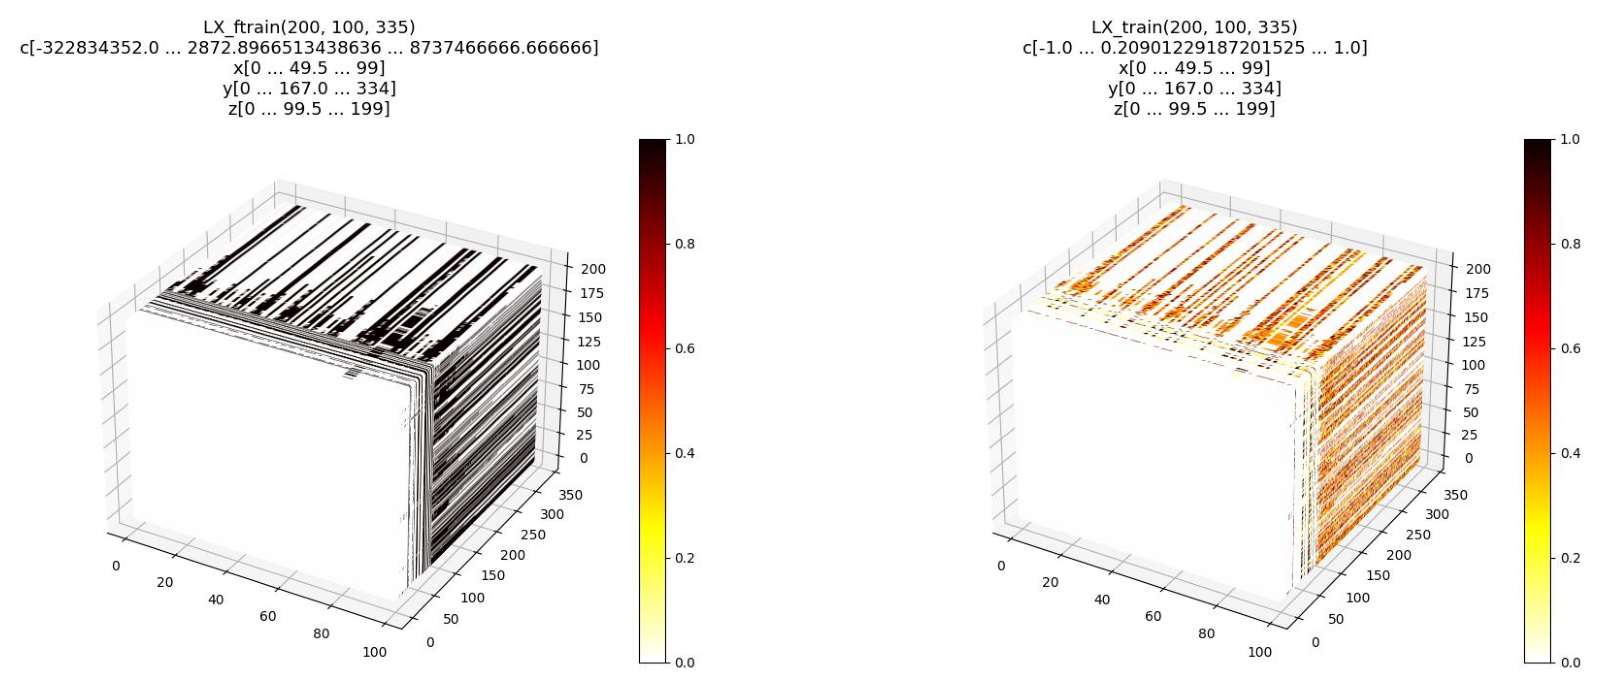

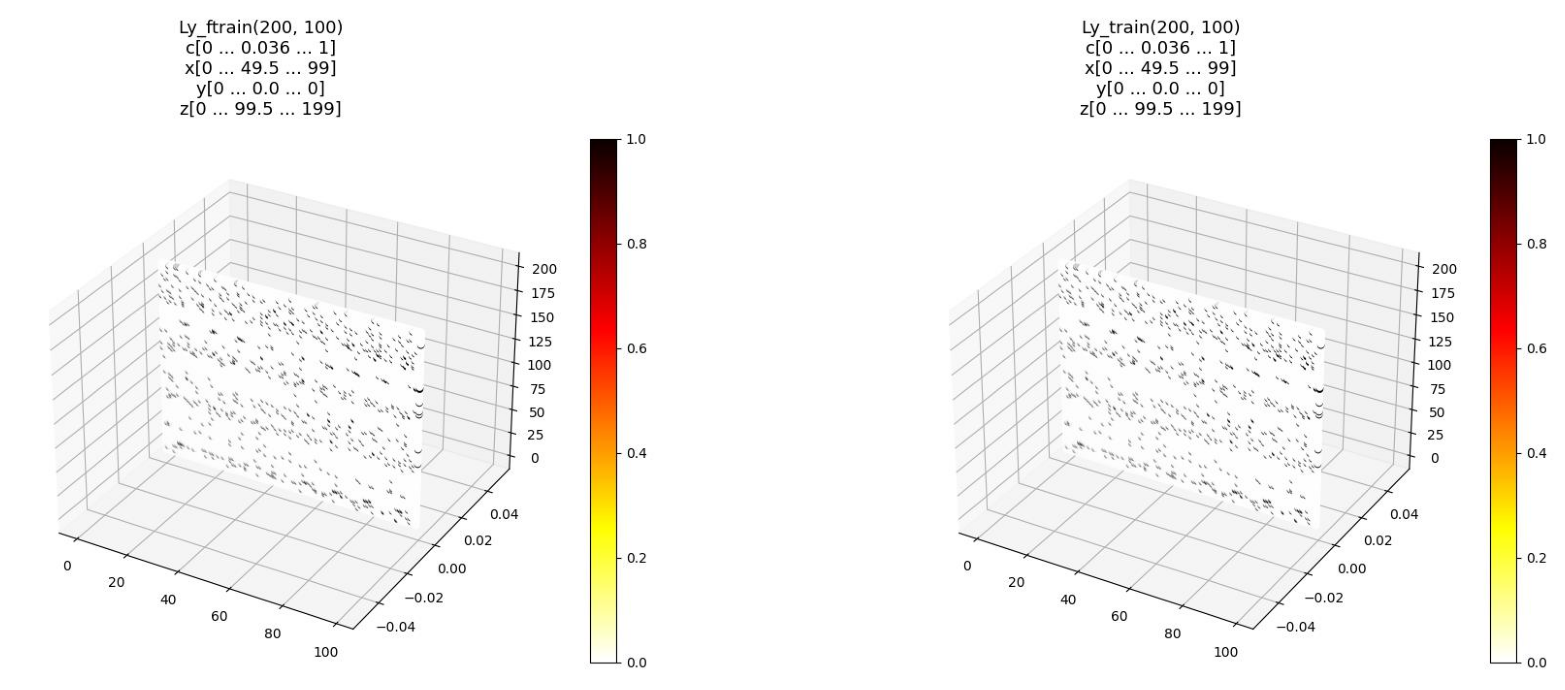

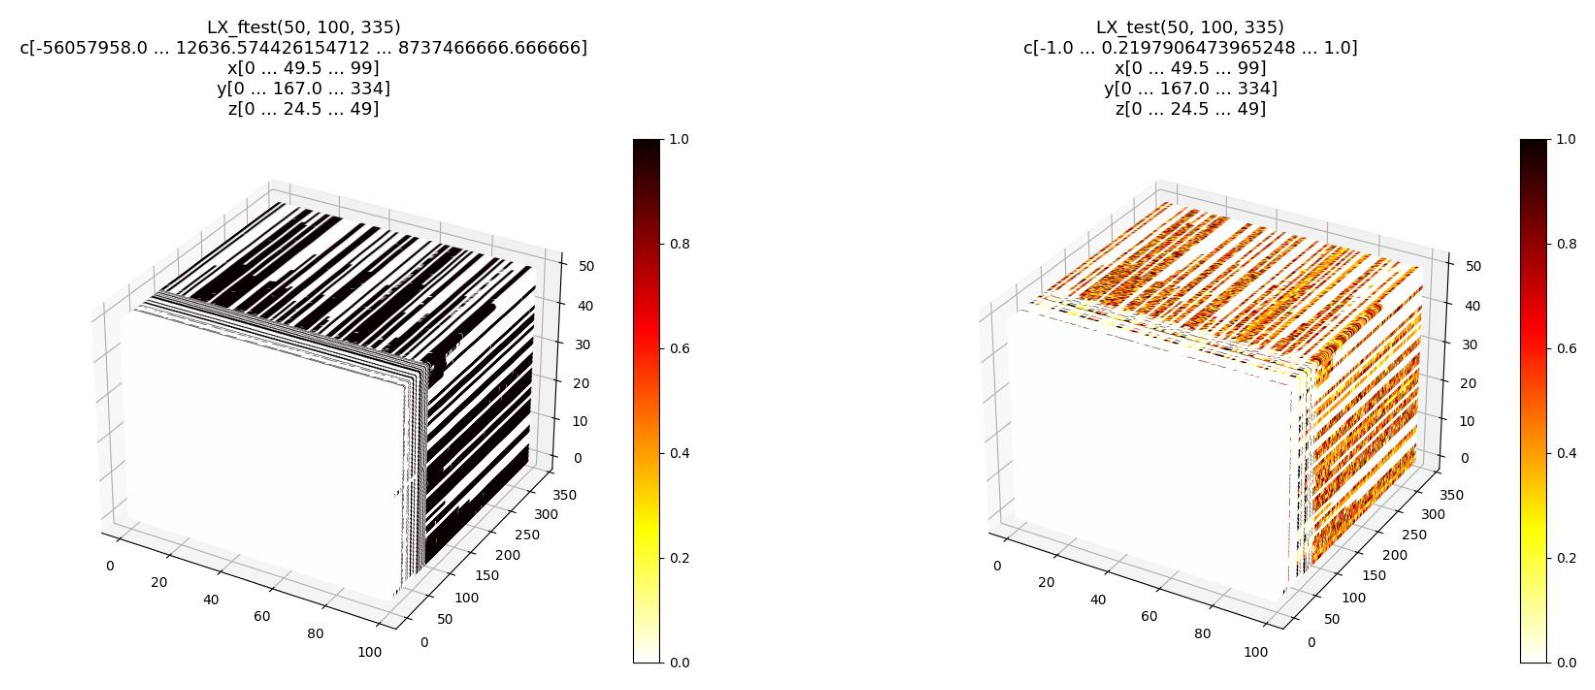

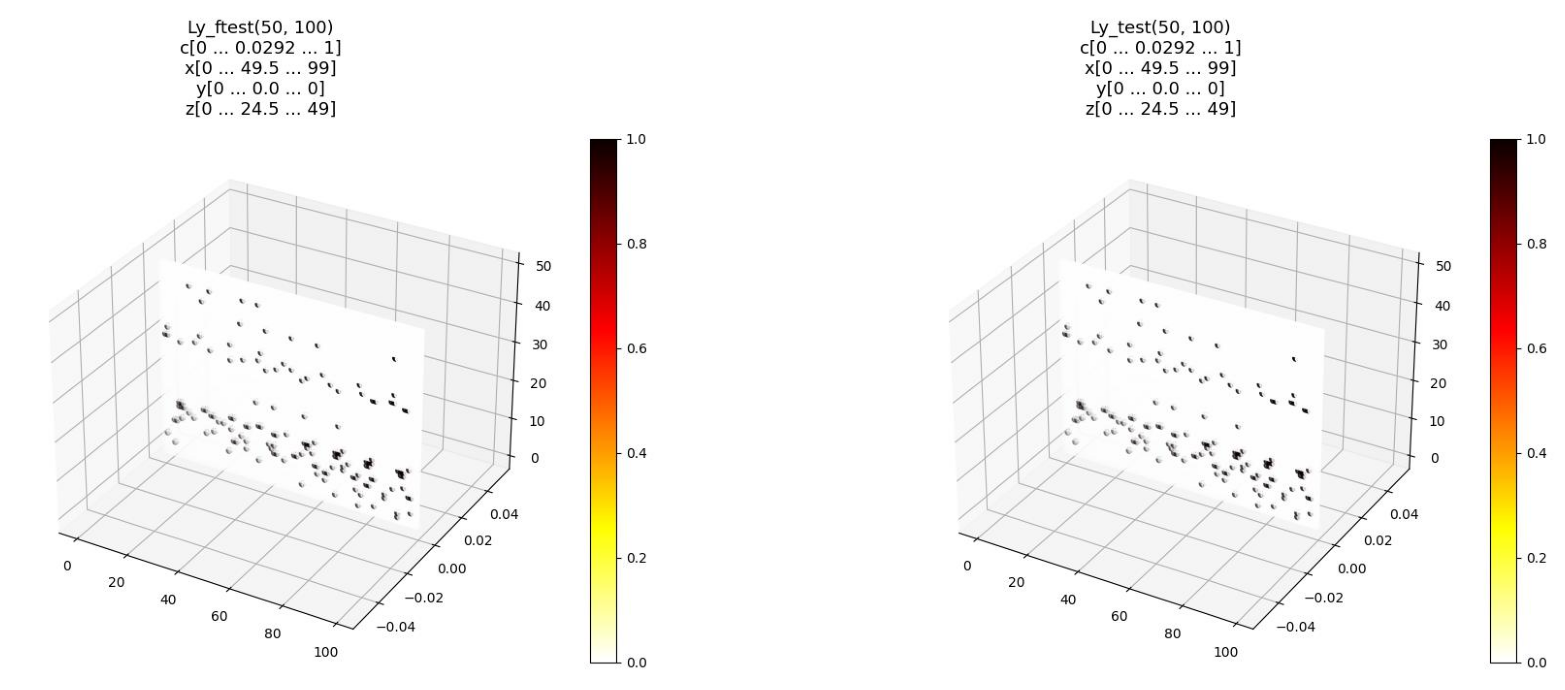

In [19]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_ftrain','LX_train'])
show_4d_imgs(['Ly_ftrain','Ly_train'])
show_4d_imgs(['LX_ftest','LX_test'])
show_4d_imgs(['Ly_ftest','Ly_test'])

# 4.INTRODUCTION

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.
To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

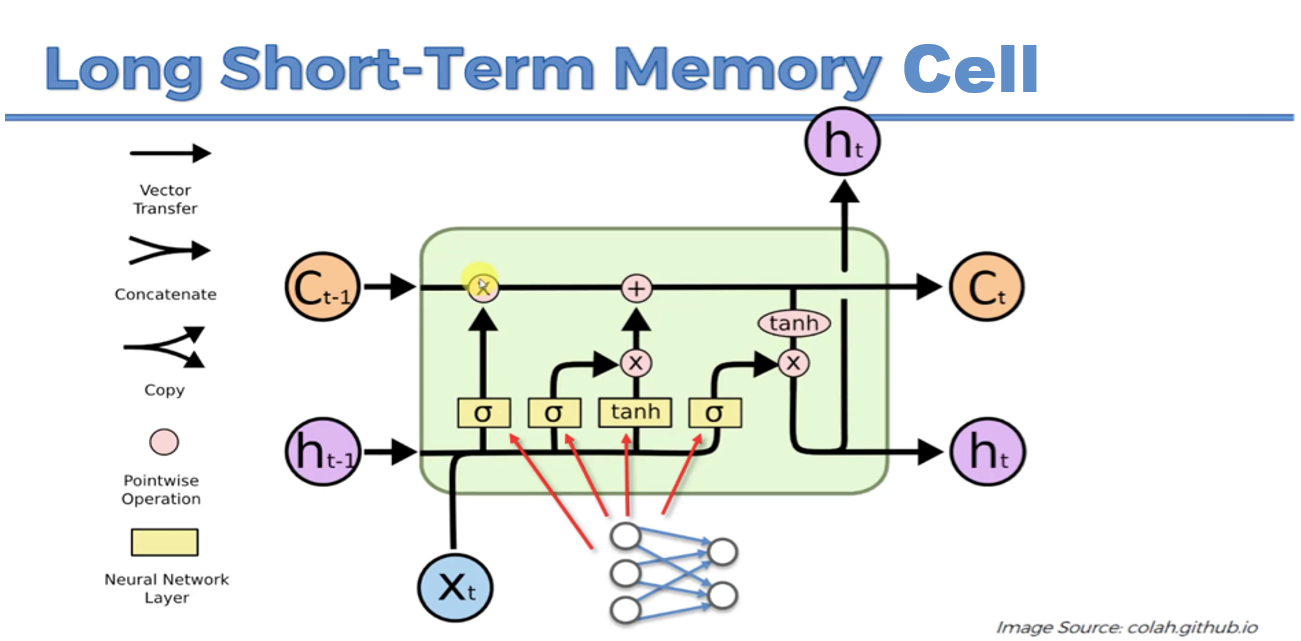

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

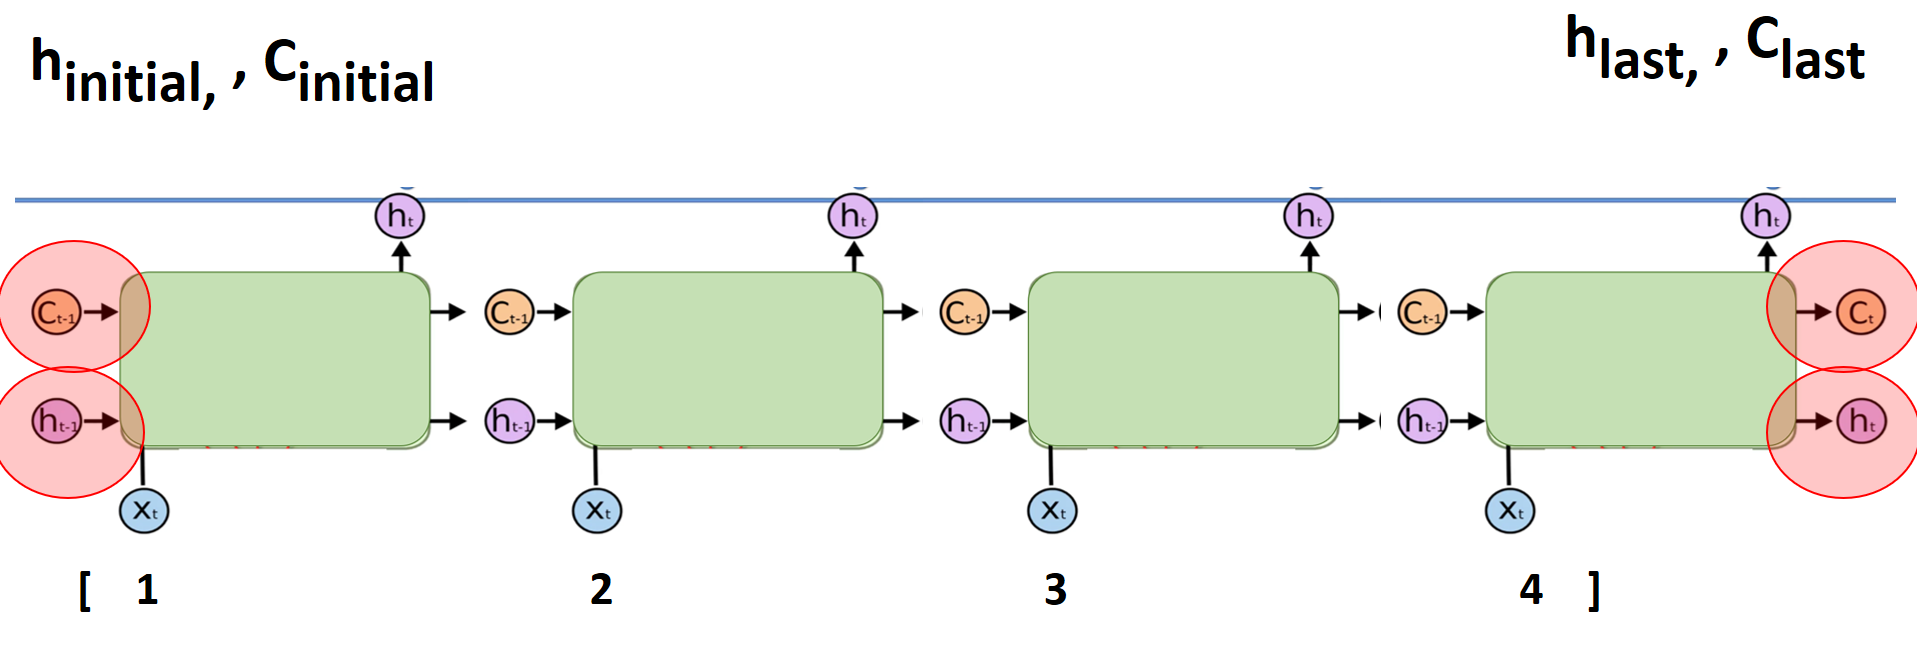

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [20]:
def new_model5():
  num_outputs = 2
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model5: Model = Model(
      inputs=
      [
        input_layer,
        #seq_in,
        state_in_h,
        state_in_c
      ],
      outputs=[logits, values, state_h, state_c])
  return model5

model5 = new_model5()
model5.summary()

h = np.zeros((train_size, cell_size), np.float32)
c = np.zeros((train_size, cell_size), np.float32)
IMG['h'], IMG['c'] = ray.get([
    show_scattered_4d.remote(h, "h"),
    show_scattered_4d.remote(c, "c"),
])

2023-01-02 10:42:45.748758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 292 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-01-02 10:42:45.749506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13129 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-01-02 10:42:45.750224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13129 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-01-02 10:42:45.750908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13129 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 335)]  0           []                               
                                                                                                  
 dense1 (Dense)                 (None, None, 128)    43008       ['inputs[0][0]']                 
                                                                                                  
 h (InputLayer)                 [(None, 256)]        0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 256)]        0           []                               
                                                                                              

## 5.2.Train



In [21]:
#@title state function

def train_state(model, x=LX_train, h=h, c=c, y=Ly_train, title=['model5', 'LX_train', 'h', 'c', 'Ly_train']):
  compile = model.predict([x, h, c])
  IMG[f"{title[4]}_predicted"], IMG[f"{title[4]}_h"], IMG[f"{title[4]}_c"] = ray.get([
    show_scattered_4d.remote(compile[1], f"{title[4]}_predicted"),
    show_scattered_4d.remote(compile[2], f"{title[4]}_h"),
    show_scattered_4d.remote(compile[3], f"{title[4]}_c"),
  ])

  show_4d_imgs([title[1], title[4], f"{title[4]}_predicted"])
  show_4d_imgs([title[1], title[2], f"{title[4]}_h"])
  show_4d_imgs([title[1], title[3], f"{title[4]}_c"])

In [22]:
#@title train state

#model5.compile("adam", "binary_crossentropy", metrics=["accuracy"])
train_state(new_model5(), LX_train, h, c, Ly_train, ['model5', 'LX_train', 'h', 'c', 'Ly_train'])

2023-01-02 10:42:49.866734: E tensorflow/stream_executor/cuda/cuda_blas.cc:226] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2023-01-02 10:42:49.866800: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:442 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError:  Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[node model_1/dense1/Tensordot/MatMul
 (defined at /usr/local/lib/python3.7/dist-packages/keras/layers/core/dense.py:202)
]] [Op:__inference_predict_function_1769]

Errors may have originated from an input operation.
Input Source operations connected to node model_1/dense1/Tensordot/MatMul:
In[0] model_1/dense1/Tensordot/Reshape:	
In[1] model_1/dense1/Tensordot/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
>>>     "__main__", mod_spec)
>>> 
>>>   File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 992, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 215, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py", line 387, in do_execute
>>>     cell_id=cell_id,
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
>>>     raw_cell, store_history, silent, shell_futures, cell_id
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
>>>     interactivity=interactivity, compiler=compiler, result=result)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_38066/2229999241.py", line 4, in <module>
>>>     train_state(new_model5(), LX_train, h, c, Ly_train, ['model5', 'LX_train', 'h', 'c', 'Ly_train'])
>>> 
>>>   File "/tmp/ipykernel_38066/3074779085.py", line 4, in train_state
>>>     compile = model.predict([x, h, c])
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py", line 452, in call
>>>     inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.7/dist-packages/keras/layers/core/dense.py", line 202, in call
>>>     outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
>>> 

In [ ]:
#@title train function

def train(model, name='model'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_train, Ly_train, batch_size=batch_size, epochs=epochs, validation_data=(LX_test, Ly_test))
  show_train_metric(history, name)


def ftrain(model, name='model'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_ftrain, Ly_ftrain, batch_size=batch_size, epochs=epochs, validation_data=(LX_ftest, Ly_ftest))
  show_train_metric(history, name)


In [ ]:
## 5.3.Infer

In [ ]:
#@title infer function

def infer(model):
  ##############LX_train
  L_result1=model.predict(LX_train)
  ##############LX_test
  L_result2=model.predict(LX_test)

  IMG['Ly_train_predicted'], IMG['Ly_test_predicted'] = ray.get([
    show_scattered_4d.remote(L_result1, "Ly_train_predicted"),
    show_scattered_4d.remote(L_result2, "Ly_test_predicted"),
  ])
  show_4d_imgs(['LX_train','Ly_train','Ly_train_predicted'])
  show_4d_imgs(['LX_test','Ly_test','Ly_test_predicted'])


def finfer(model):
  ##############LX_ftrain
  L_fresult1=model.predict(LX_ftrain)
  ##############LX_ftest
  L_fresult2=model.predict(LX_ftest)

  IMG['Ly_ftrain_predicted'], IMG['Ly_ftest_predicted'] = ray.get([
    show_scattered_4d.remote(L_fresult1, "Ly_ftrain_predicted"),
    show_scattered_4d.remote(L_fresult2, "Ly_ftest_predicted"),
  ])
  show_4d_imgs(['LX_ftrain','Ly_ftrain','Ly_ftrain_predicted'])
  show_4d_imgs(['LX_ftest','Ly_ftest','Ly_ftest_predicted'])


___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [ ]:
def new_model6():
  num_outputs = 10
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  #state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  #state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  #tf.nn.sigmoid
  dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      #initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model6: Model = Model(
      inputs=input_layer,
      #[
      #  input_layer, #seq_in,
      #  state_in_h,
      #  state_in_c
      #],
      outputs=values
      #[
      #  logits,
      #  values,
      #  state_h,
      #  state_c
      #]
      )
  return model6

model6 = new_model6()
model6.summary()

## 6.2.Train



In [ ]:
#train(model6, 'model6')
ftrain(model6, 'model6')

## 6.3.Infer



In [ ]:
#infer(model6)
finfer(model6)

# 7.MODEL WEIGHTS SUMMARY

In [ ]:
weights5 = show_weights(model5, 'model5')
weights6 = show_weights(model6, 'model6')

show_4d_imgs(weights5)
show_4d_imgs(weights6)